## Import Libraries

In [1]:
import segysak as sg
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import warnings
warnings.filterwarnings('ignore')

### Set the Segy File Path

In [2]:
V3D_path = pathlib.Path("f03-crop2-petrel.sgy")
print("3D Seismic Data-", V3D_path, V3D_path.exists())

3D Seismic Data- f03-crop2-petrel.sgy True


### Check the EBCIDIC Header for the Seismic File

In [3]:
from segysak.segy import get_segy_texthead
get_segy_texthead(V3D_path)

Text HeaderC 1 SEGY OUTPUT FROM Petrel 2018.2 Sunday, December 13 2020 22:55:17
C 2 Name: original ÝCrop¨ 1 ÝRealized¨ 1 ÝCrop¨ 1 ÝCrop¨ 1 Type: 3D seismic
C 3
C 4 First inline: 198    Last inline: 512
C 5 First xline:  672    Last xline:  1113
C 6 CRS: Undefined
C 7 X min: 614831.38 max: 626097.21 delta: 11265.83
C 8 Y min: 6076252.36 max: 6084432.82 delta: 8180.46
C 9 Time min: -1114.00 max: -338.00 delta: 776.00
C10 Lat min: - max: - delta: -
C11 Long min: - max: - delta: -
C12 Trace min: -1112.00 max: -340.00 delta: 772.00
C13 Seismic (template) min: -28620.57 max: 25043.00 delta: 53663.57
C14 Amplitude (data) min: -28620.57 max: 25043.00 delta: 53663.57
C15 Trace sample format: IEEE floating point
C16 Coordinate scale factor: 100.00000
C17
C18 Binary header locations:
C19 Sample interval             : bytes 17-18
C20 Number of samples per trace : bytes 21-22
C21 Trace date format           : bytes 25-26
C22
C23 Trace header locations:
C24 Inline number               : bytes 5-8
C25 Xline number                : bytes 21-24
C26 Coordinate scale factor     : bytes 71-72
C27 X coordinate                : bytes 73-76
C28 Y coordinate                : bytes 77-80
C29 Trace start time/depth      : bytes 109-110
C30 Number of samples per trace : bytes 115-116
C31 Sample interval             : bytes 117-118
C32
C33
C34
C35
C36
C37
C38
C39
C40 END EBCDIC

### Import the Seismic File and convert into a format usable by Python

In [4]:
from segysak.segy import segy_loader, well_known_byte_locs
f03= segy_loader(V3D_path, iline = 5,  xline = 21, cdpx = 73, cdpy = 77, vert_domain='TWT')
segy_file = 'f03-crop2-petrel.sgy'


Loading as 3D
Fast direction is CDP


### Display the inline 200

Text(0.5, 0, 'XLINE')

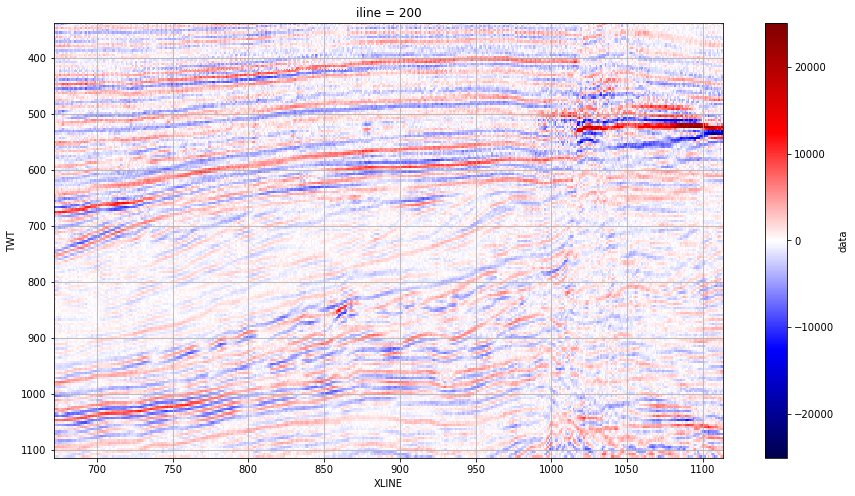

In [5]:
fig, ax1 = plt.subplots(ncols=1, figsize = (15,8))
iline_sel = 200
f03.data.transpose('twt', 'iline', 'xline', transpose_coords=True).sel(iline = iline_sel).plot(yincrease=False, cmap = 'seismic')
plt.grid('grey')
plt.ylabel('TWT')
plt.xlabel('XLINE')

### Lets look at the size of the Seismic Volume

In [6]:
print('Loaded cube size: {}'.format(f03.seis.humanbytes))

Loaded cube size: 105.17 MB


### Import Horizon File

In [7]:
hrz_file = './fs4-horizon.csv'
hrz = pd.read_csv(hrz_file, names=["cdp_x","cdp_y","twt"], sep='\,')
hrz.head()

,cdp_x,cdp_y,twt
0,605835.52,6073556.38,1125.63
1,605860.51,6073557.08,1125.62
2,605885.50,6073557.78,1125.61
3,605910.49,6073558.48,1125.57
4,605935.48,6073559.18,1125.46


### Load Seismic Horizon 

In [8]:
f03.seis.calc_corner_points()
corners = np.array(f03.attrs['corner_points_xy'])
corners

array([[ 615063.52, 6076264.96],
       [ 626084.36, 6076573.44],
       [ 625865.08, 6084419.84],
       [ 614844.24, 6084112.  ]])

In [9]:
from scipy.interpolate import griddata

xi = np.linspace(hrz.cdp_x.min(), hrz.cdp_x.max(), 250)
yi = np.linspace(hrz.cdp_y.min(), hrz.cdp_y.max(), 2500)
X, Y = np.meshgrid(xi, yi)
Z = griddata((hrz.cdp_x, hrz.cdp_y), hrz.twt, (X,Y))

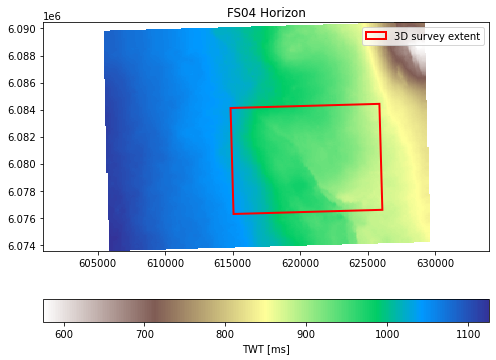

In [10]:
from matplotlib.patches import Polygon
survey_limits = Polygon(corners, fill=False, edgecolor='r',
                        linewidth=2, label='3D survey extent')

f, ax = plt.subplots(figsize=(8,6))
pp = ax.pcolormesh(X, Y, Z, cmap='terrain_r')
f.colorbar(pp, orientation='horizontal', label='TWT [ms]')
ax.add_patch(survey_limits)
ax.axis('equal')
ax.legend()
ax.set_title('FS04 Horizon');

### Extract Amplitude alon the horizon

In [11]:
hrz_mapped =f03.seis.surface_from_points(hrz, 'twt', right=('cdp_x', 'cdp_y'))

In [12]:
amp = f03.data.interp({'iline':hrz_mapped.iline,
                        'xline':hrz_mapped.xline,
                        'twt':hrz_mapped.twt})

### Calculate values to properly scale the colormap

In [13]:
minamp, maxamp = f03.attrs['percentiles'][1], f03.attrs['percentiles'][-2]

In [14]:
xmin, xmax = corners[:,0].min(), corners[:,0].max()
ymin, ymax = corners[:,1].min(), corners[:,1].max()

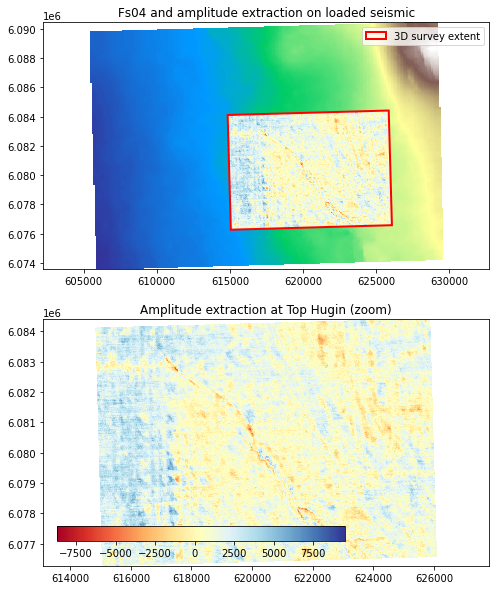

In [15]:
survey_limits = Polygon(corners, fill=False, edgecolor='r',
                        linewidth=2, label='3D survey extent')

f, ax = plt.subplots(nrows=2, figsize=(8,10))
ax[0].pcolormesh(X, Y, Z, cmap='terrain_r')
ax[0].add_patch(survey_limits)
for aa in ax:
    hh = aa.pcolormesh(amp.cdp_x, amp.cdp_y, amp.data, cmap='RdYlBu',
                   vmin=minamp, vmax=maxamp)
    aa.axis('equal')
ax[0].legend()
ax[1].set_xlim(xmin, xmax)
ax[1].set_ylim(ymin, ymax)
ax[0].set_title('Fs04 and amplitude extraction on loaded seismic')
ax[1].set_title('Amplitude extraction at Top Hugin (zoom)')
cax = f.add_axes([0.15, 0.16, 0.5, 0.02])
f.colorbar(hh, cax=cax, orientation='horizontal');

### Display Horoizon in Section View

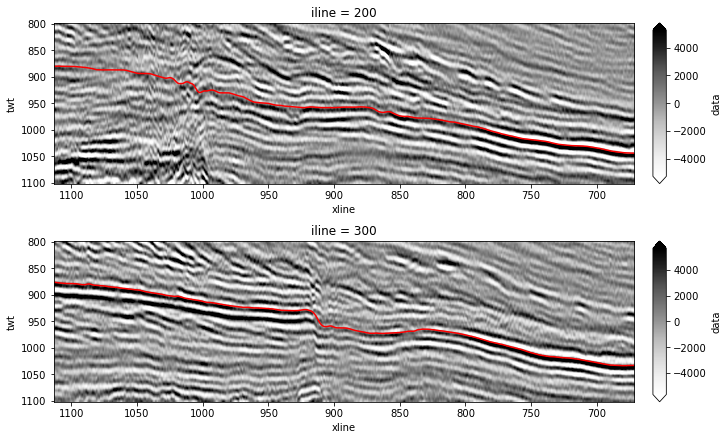

In [16]:
opt = dict(x='xline', y='twt', add_colorbar=True,
        interpolation='spline16', robust=True,
        yincrease=False, cmap='Greys')

inl_sel = [200, 300]

f, ax = plt.subplots(nrows=2, figsize=(10, 6), sharey=True,
                     constrained_layout=True)
for i, val in enumerate(inl_sel):
    f03.data.sel(iline=val, twt=slice(800,1100)).plot.imshow(ax=ax[i], **opt)
    x, t = hrz_mapped.sel(iline=val).xline, hrz_mapped.sel(iline=val).twt
    ax[i].plot(x, t, color='r')
    ax[i].invert_xaxis()

In [17]:
mask_below = f03.where(f03.twt < hrz_mapped.twt + 100)
mask_above = f03.where(f03.twt > hrz_mapped.twt)
masks = [mask_above, mask_below]

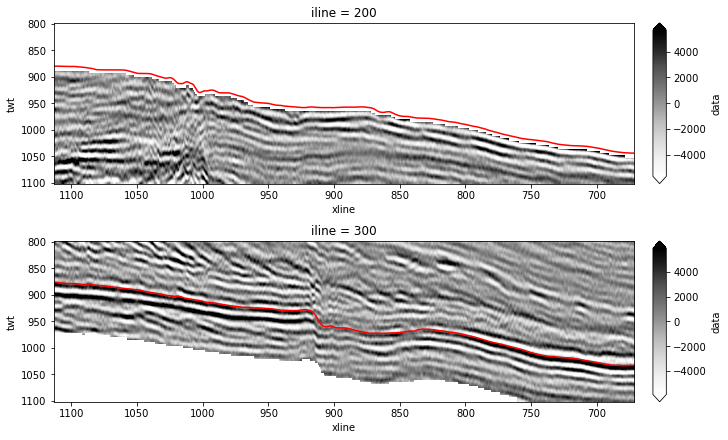

In [18]:
opt = dict(x='xline', y='twt', add_colorbar=True,
        interpolation='spline16', robust=True,
        yincrease=False, cmap='Greys')

inl_sel = [200, 300]

f, ax = plt.subplots(nrows=2, figsize=(10, 6), sharey=True,
                     constrained_layout=True)
for i, val in enumerate(inl_sel,):
    masks[i].data.sel(iline=val, twt=slice(800,1100)).plot.imshow(ax=ax[i], **opt)
    x, t = hrz_mapped.sel(iline=val).xline, hrz_mapped.sel(iline=val).twt
    ax[i].plot(x, t, color='r')
    ax[i].invert_xaxis()

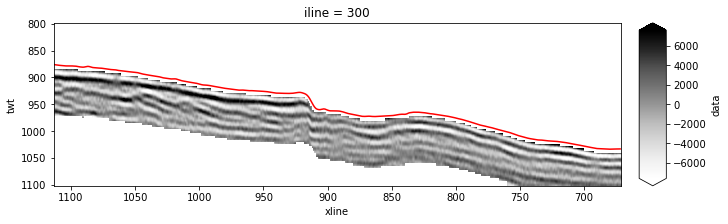

In [19]:
opt = dict(x='xline', y='twt', add_colorbar=True,
        interpolation='spline16', robust=True,
        yincrease=False, cmap='Greys')

inl_sel = [200, 300]

f, ax = plt.subplots(nrows=1, figsize=(10, 3), sharey=True,
                     constrained_layout=True)

masked_data = 0.5*(mask_below + mask_above)

masked_data.data.sel(iline=val, twt=slice(800,1100)).plot.imshow(ax=ax, **opt)
x, t = hrz_mapped.sel(iline=val).xline, hrz_mapped.sel(iline=val).twt
ax.plot(x, t, color='r')
ax.invert_xaxis()

Text(0.5, 1.0, 'Sum of amplitudes FS04 +100ms')

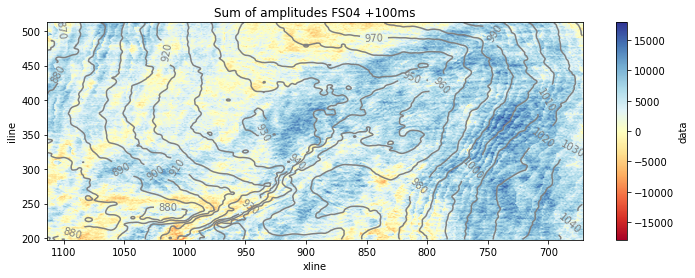

In [20]:
summed_amp = masked_data.sum(dim='twt')

f, ax = plt.subplots(figsize=(12,4))
summed_amp.data.plot.imshow(cmap='RdYlBu', interpolation='spline16', )
cs = plt.contour(amp.xline, amp.iline, hrz_mapped.twt, levels=20, colors='grey')
plt.clabel(cs, fontsize=10, fmt='%.0f')
ax.invert_xaxis()
ax.set_title('Sum of amplitudes FS04 +100ms')